In [1]:
import math
import torch

In [2]:
torch.set_grad_enabled(False)

In [3]:
# This will be our main class from which a lot of other classes will inherit (e.g. fully connected layer)
class Module(object):
    def __init__(self):
        self.output = None
        self.grad_input = None
    
    def forward(self, inpt):
        return self.update_output(inpt)

    def backward(self, inpt, grad_output):
        self.update_grad_input(inpt, grad_output)
        self.acc_grad_params(inpt, grad_output)
        return self.grad_input
    
    def update_output(self, inpt):        
        pass

    # gradient with respect to input
    def update_grad_input(self, inpt, grad_output):       
        pass   
    
    # gradient with respect to parameters
    def acc_grad_params(self, inpt, grad_output):
        pass
    
    def zero_grad_params(self): 
        pass
        
    def get_params(self):
        return []
        
    def get_grad_params(self):
        return []
    
    def __repr__(self):
        return "Module"

In [4]:
# this is a container class like keras's Sequential model
class Sequential(Module):    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.y = []
   
    def add(self, module):
        self.modules.append(module)

    def update_output(self, inpt): 
        self.y = [] 

        y_p = self.modules[0].forward(inpt)
        self.y.append(y_p)
        for i in range(1,len(self.modules)):
            y_n = self.modules[i].forward(y_p)
            self.y.append(y_n)
            y_p = y_n
        
        self.output = y_n
            
        return self.output

    def backward(self, inpt, grad_output): 
        n = len(self.modules)
        g_n = self.modules[n-1].backward(self.y[n-2],grad_output)
        #debugging
#         print(n-1,self.modules[n-1])
        for i in range(n-2,0,-1):
#             print(i,self.modules[i])
            g_p = self.modules[i].backward(self.y[i-1],g_n)
            g_n = g_p
            
        self.grad_input = self.modules[0].backward(inpt,g_p)
        return self.grad_input

    def zero_grad_params(self): 
        for module in self.modules:
            module.zero_grad_params()
    
    def get_params(self):
        return [x.get_params() for x in self.modules]
    
    def get_grad_params(self):
        return [x.get_grad_params() for x in self.modules]
    
    def __repr__(self):
        return "".join([str(x) + '\n' for x in self.modules])
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)

In [5]:
# input: batch_size x n_features1
# output: batch_size x n_features2

class DenseLayer(Module):
    def __init__(self, n_in, n_out):
        super(DenseLayer, self).__init__()
       
        #initializing weights 
        stdv = 1./math.sqrt(n_in)
        self.W = torch.FloatTensor(n_out,n_in).uniform_(-stdv,stdv)
        self.b = torch.FloatTensor(n_out).uniform_(-stdv,stdv)
        
        self.gradW = torch.zeros_like(self.W)
        self.gradb = torch.zeros_like(self.b)
    
    def update_output(self, inpt):
        self.output = torch.mm(inpt,self.W.T) + self.b  
        return self.output

    def update_grad_input(self, inpt, grad_output):
        self.grad_input = torch.mm(grad_output,self.W)
        return self.grad_input
    
    def acc_grad_params(self, inpt, grad_output):
        self.gradW = torch.mm(grad_output.T,inpt)
        self.gradb = grad_output.sum(axis=0) 
    
    def zero_grad_params(self):
        self.gradW = torch.zeros_like(self.gradW)
        self.gradb = torch.zeros_like(self.gradb)
        
    def get_params(self):
        return [self.W, self.b]
    
    def get_grad_params(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        return 'Linear %d -> %d' %(s[1],s[0])

In [6]:
d_layer = DenseLayer(2, 30)

In [7]:
d_layer.get_grad_params()

[tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.])]

In [8]:
d_layer.get_params()

[tensor([[ 0.4406,  0.4917],
         [ 0.5681, -0.5828],
         [ 0.3186, -0.6972],
         [ 0.6869,  0.5916],
         [ 0.0973,  0.3417],
         [ 0.4669,  0.4593],
         [ 0.1802, -0.0619],
         [ 0.5712, -0.4907],
         [-0.4167,  0.0180],
         [-0.4434, -0.5455],
         [-0.3208, -0.0565],
         [-0.2551, -0.4475],
         [ 0.3236, -0.6054],
         [-0.6785, -0.4860],
         [-0.2289, -0.5104],
         [ 0.7045, -0.6910],
         [ 0.5066, -0.1273],
         [-0.2033, -0.2529],
         [-0.6460, -0.2975],
         [ 0.4203, -0.3016],
         [ 0.0889,  0.2669],
         [-0.1797, -0.6461],
         [-0.3836, -0.3457],
         [ 0.4956, -0.4591],
         [-0.3308, -0.0072],
         [-0.2273,  0.4961],
         [ 0.2557,  0.4314],
         [ 0.4155,  0.0733],
         [-0.7059,  0.6726],
         [ 0.0733,  0.1287]]),
 tensor([-3.2561e-01,  5.5539e-01,  1.4360e-01,  4.0883e-04, -1.6502e-01,
          3.1923e-01, -3.0146e-01, -3.1361e-01, -2.214

---------------------------------------------------------------------------------------------------------------------

In [9]:
class Tanh(Module):
    def __init__(self):
         super(Tanh, self).__init__()
    
    def update_output(self, inpt):
        self.output = 2/(1+torch.exp(-2*inpt)) - 1
        return self.output
    
    def update_grad_input(self, inpt, grad_output):
        self.grad_input = (1 - self.output**2)*grad_output
        return self.grad_input

    def __repr__(self):
        return "Tanh"

In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def update_output(self, inpt):
        self.output = torch.max(inpt,torch.zeros_like(inpt))
        return self.output
    
    def update_grad_input(self, inpt, grad_output):
        inpt[inpt<=0] = 0
        inpt[inpt>0] = 1
        self.grad_input = grad_output * inpt
        return self.grad_input
    
    def __repr__(self):
        return "ReLU"

In [11]:
BB = torch.tensor([[1.,5.,6.],[-5.,3.,10.],[-1.,-1.,-10.],[2.,2.,4.]])
BB

tensor([[  1.,   5.,   6.],
        [ -5.,   3.,  10.],
        [ -1.,  -1., -10.],
        [  2.,   2.,   4.]])

In [12]:
torch.tanh(BB)

tensor([[ 0.7616,  0.9999,  1.0000],
        [-0.9999,  0.9951,  1.0000],
        [-0.7616, -0.7616, -1.0000],
        [ 0.9640,  0.9640,  0.9993]])

In [13]:
my_tanh = Tanh()

my_tanh.update_output(BB)

tensor([[ 0.7616,  0.9999,  1.0000],
        [-0.9999,  0.9951,  1.0000],
        [-0.7616, -0.7616, -1.0000],
        [ 0.9640,  0.9640,  0.9993]])

---------------------------------------------------------------------------------------------------------------------

In [14]:
class Loss(object):
    def __init__ (self):
        self.output = None
        self.grad_input = None
    
    def forward(self, inpt, target):
        return self.update_output(inpt, target)

    def backward(self, inpt, target):
        return self.update_grad_input(inpt, target)
    
    def update_output(self, inpt, target):
        return self.output

    def update_grad_input(self, inpt, target):
        return self.grad_input  

    def __repr__(self):
        return "Loss"

In [15]:
class MSE(Loss):
    def __init__(self):
        super(MSE, self).__init__()

    def update_output(self, inpt, target):   
        self.output = torch.sum((target - inpt)**2)/inpt.shape[0]
        return self.output 
 
    def update_grad_input(self, inpt, target):
        self.grad_input = -2*(target-inpt)/inpt.shape[0]
        return self.grad_input

    def __repr__(self):
        return "MSE"

In [16]:
BB

tensor([[  1.,   5.,   6.],
        [ -5.,   3.,  10.],
        [ -1.,  -1., -10.],
        [  2.,   2.,   4.]])

In [17]:
trg = torch.tensor([[  2.,   5.,   6.],
        [ -8.,   4.,  11.],
        [ -2.,  -1., -10.],
        [  0.,   0.,   5.]])

In [18]:
mse = MSE()

mse.update_output(BB,trg)

tensor(5.5000)

---------------------------------------------------------------------------------------------------------------------

In [19]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
matplotlib.style.use('ggplot')

In [20]:
train_size = 1000
test_size = 1000

X_train = torch.empty(train_size, 2).uniform_(0, 1)
X_test = torch.empty(train_size, 2).uniform_(0, 1)

X = torch.cat((X_train,X_test))

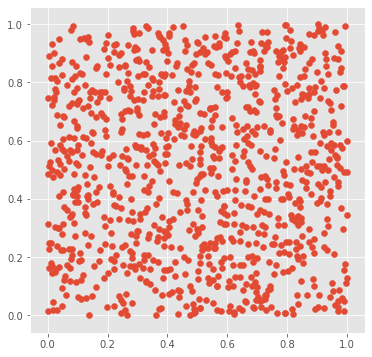

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0],X_train[:,1])
plt.show()

In [22]:
Y = torch.zeros((train_size+test_size,2))

In [23]:
Y

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [24]:
for index,each in enumerate(X):
    if (each[0] - 0.5)**2 + (each[1] - 0.5)**2 <= 1/(2*math.pi):
        Y[index][1] = 1
    else:
        Y[index][0] = 1

In [25]:
Y

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [26]:
torch.argmax(Y,axis=1)

tensor([0, 1, 1,  ..., 0, 1, 0])

In [27]:
Y_train = Y[:1000]
Y_test = Y[1000:]

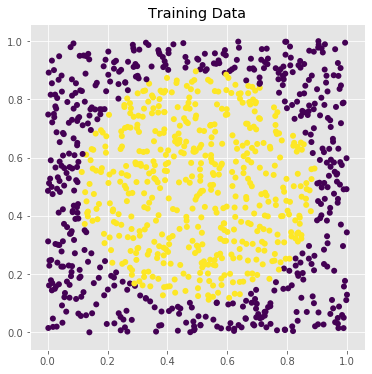

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0],X_train[:,1],c=torch.argmax(Y_train,axis=1), edgecolors='none')
plt.title('Training Data')
plt.show()

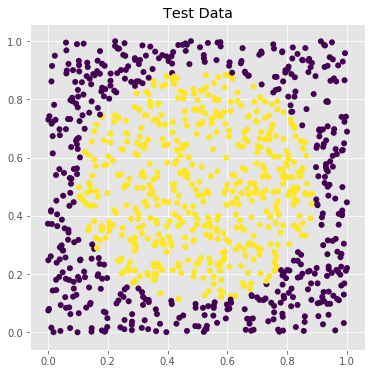

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0],X_test[:,1],c=torch.argmax(Y_test,axis=1), edgecolors='none')
plt.title('Test Data')
plt.show()

In [30]:
net_loss = MSE()

net = Sequential()
net.add(DenseLayer(2, 25))
net.add(ReLU())
net.add(DenseLayer(25, 25))
net.add(ReLU())
net.add(DenseLayer(25, 25))
net.add(ReLU())
net.add(DenseLayer(25, 2))

print(net)

Linear 2 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 2



In [31]:
# net.get_params()

In [32]:
def sgd(x, dx, config):
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            torch.add(cur_x, -cur_old_grad, out=cur_x)

In [33]:
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # shuffle
    indices = torch.randperm(n_samples)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [34]:
optimizer_config = {'learning_rate' : 0.005}
n_epoch = 40
batch_size = 64

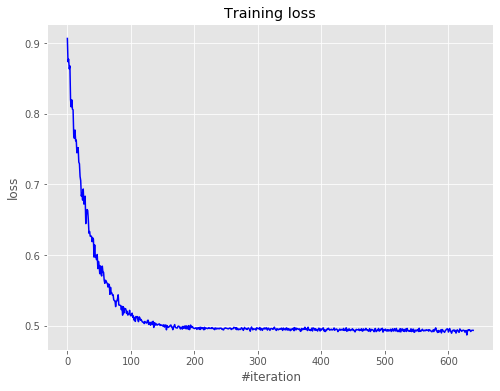

Current loss: 0.493205


In [35]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, Y_train, batch_size):
        net.zero_grad_params()

        # Forward
        pred = net.forward(x_batch)
        loss = net_loss.forward(pred, y_batch)
    
        # Backward
        lg = net_loss.backward(pred, y_batch)
        net.backward(x_batch, lg)
        
        # Update weights
        sgd(net.get_params(), 
            net.get_grad_params(), 
            optimizer_config)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [36]:
net.forward(X_train), Y_train

(tensor([[0.5152, 0.4982],
         [0.4972, 0.5036],
         [0.4983, 0.5034],
         ...,
         [0.4975, 0.4906],
         [0.4917, 0.4914],
         [0.5044, 0.4844]]), tensor([[1., 0.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]]))

In [37]:
net.forward(X_test), Y_test

(tensor([[0.5091, 0.4855],
         [0.5182, 0.4692],
         [0.5087, 0.4886],
         ...,
         [0.5007, 0.5022],
         [0.5030, 0.4958],
         [0.4993, 0.4994]]), tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [0., 1.],
         [1., 0.]]))

In [38]:
mse = MSE()
print(mse.update_output(X_train,Y_train))
print(mse.update_output(X_test,Y_test))

tensor(0.6742)
tensor(0.6610)


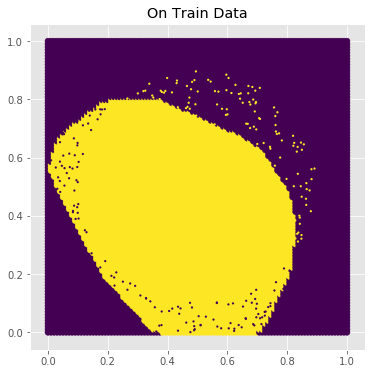

In [41]:
x1, x2 = torch.meshgrid(torch.linspace(0, 1), torch.linspace(0, 1))
x1_flat = x1.flatten()
x2_flat = x2.flatten()

x_full = torch.stack([x1_flat, x2_flat]).T
c = torch.argmax(net.forward(x_full), axis=1).reshape(x1.shape)

plt.figure(figsize=(6,6))
plt.scatter(x1, x2, c=c)
plt.scatter(X_train[:,0],X_train[:,1], c = torch.argmax(Y_train, axis=1), edgecolors= "none", s = 5)
plt.title('On Train Data')
plt.show()

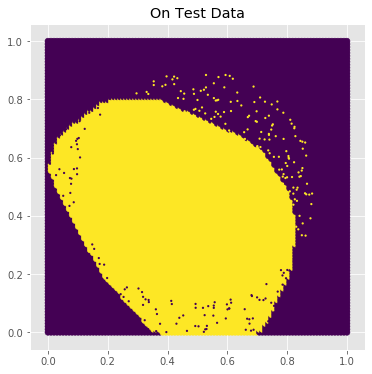

In [42]:
plt.figure(figsize=(6,6))
plt.scatter(x1, x2, c=c)
plt.scatter(X_test[:,0],X_test[:,1], c = torch.argmax(Y_test, axis=1), edgecolors= "none", s = 5)
plt.title('On Test Data')
plt.show()

In [ ]:
aa = torch.tensor([[1,2,3],[4,5,6]])

aa

In [ ]:
bb = torch.tensor([[1,1],[1,1]])

bb

In [ ]:
torch.mm(bb,aa)

In [ ]:
aa.T

In [ ]:
# EXPERIMENTING

# class Animal(object):
#     def __init__(self,domestic,colour):
#         self.name = None
#         self.domestic = domestic
#         self.colour = colour
    
#     def sound(self):
#         pass
    
#     def reality(self):
#         print('Humans are more clever than any other animal on the planet')
        
#     def __repr__(self):
#         return "Module"
        

# class Haski(Animal):
#     def __init__(self, domestic, colour, name):
#         super().__init__(domestic,colour)
#         self.name = name
        
#     def sound(self):
#         print('Haf-Haf')
        
#     def __repr__(self):
#         return "Dog"

In [ ]:
# my_dog = Haski(True,'White','Leo')
# my_dog.reality()